In [ ]:
!pip install tensorflowjs

In [2]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
# import tensorflowjs as tfjs
import matplotlib
matplotlib.style.use('ggplot')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = 'drive/MyDrive/recycle_dataset' #path to dataset



In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
    # zoom_range=.2,
    # horizontal_flip=True,
    # rotation_range=30,
    # shear_range = 10,
    # width_shift_range=.2,
    # height_shift_range=.2
)
train_generator = datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    shuffle=True,
    target_size=IMAGE_SHAPE,
    
)
valid_generator=datagen.flow_from_directory(TRAINING_DATA_DIR,target_size=(224,224),subset='validation',batch_size = 32)

# test_generator = datagen.flow_from_directory(
#     VALID_DATA_DIR,
#     shuffle=False,
#     target_size=IMAGE_SHAPE,
#     batch_size = 1
# )

Found 468 images belonging to 4 classes.
Found 45 images belonging to 4 classes.


In [11]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet152
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import DenseNet169
from keras.applications.mobilenet_v2 import MobileNetV2

model = MobileNetV2(include_top = False,input_shape=(224,224,3),weights = 'imagenet')
model.trainable = False
print(model.layers[0].output.shape)

conv = tf.keras.layers.Conv2D(512,2,1,'valid',activation='relu')((model.layers[-1].output))
gmax = tf.keras.layers.GlobalMaxPooling2D()(conv)
flat1 = Flatten()(gmax)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(4, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)
model.summary()

(None, 224, 224, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                       

In [12]:
model.compile(
          loss      = tf.keras.losses.CategoricalCrossentropy(),
          metrics   = tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam())
# fit 
model.fit(train_generator,validation_data=valid_generator ,epochs=3)

Epoch 1/3
15/15 [==============================] - 8s 261ms/step - loss: 3.2035 - categorical_accuracy: 0.6880 - val_loss: 0.4526 - val_categorical_accuracy: 0.9111
Epoch 2/3
15/15 [==============================] - 2s 152ms/step - loss: 0.1015 - categorical_accuracy: 0.9701 - val_loss: 0.1203 - val_categorical_accuracy: 0.9778
Epoch 3/3
15/15 [==============================] - 2s 154ms/step - loss: 0.0091 - categorical_accuracy: 0.9979 - val_loss: 0.0079 - val_categorical_accuracy: 1.0000


In [ ]:
model.evaluate(valid_generator)
model.save("model.h5")

2/2 [==============================] - 0s 29ms/step - loss: 0.0013 - categorical_accuracy: 1.0000


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# model = tf.keras.models.load_model("recycle_model.h5")
# model.evaluate(valid_generator)

In [ ]:
# !zip -r /content/recycle_weights.zip /content/recycle_weights

  adding: content/recycle_weights/ (stored 0%)
  adding: content/recycle_weights/group1-shard1of3.bin (deflated 7%)
  adding: content/recycle_weights/model.json (deflated 96%)
  adding: content/recycle_weights/group1-shard3of3.bin (deflated 7%)
  adding: content/recycle_weights/group1-shard2of3.bin (deflated 7%)


In [ ]:
# from google.colab import files
# files.download("/content/recycle_weights.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# tfjs.converters.save_keras_model(model, "drive/MyDrive/recycle_dataset/")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [13]:
import cv2
import numpy as np
import json
model = tf.keras.models.load_model("model.h5")
image = cv2.imread('drive/MyDrive/recycle_dataset/Can/can020.jpg')
image = cv2.resize(image,(224,224))
image = np.array(image, dtype=np.float32)
image = image/255
image = np.expand_dims(image, axis=0)
class_dict = {0:"can", 1:"chips_packets", 2:"paper_bag", 3:"plastic_bottle"}
# print(class_dict)
x = model.predict(image)
# print(x)
argmax = np.argmax(x[0])
# print(np.argmax(x[0]))
# print(max(x[0]))
mx = max(x[0])
sum = np.sum(x)
accuracy = (mx/sum)*100
predicted_dict = {"item":class_dict[argmax], "certainity": accuracy/100}
predicted_json = json.dumps(predicted_dict, indent = 4)
print(predicted_json)

OSError: ignored

In [14]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        with tf.GradientTape() as tape:

            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    

        grads = tape.gradient(loss, convOutputs)

        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

In [18]:

train_generator.class_indices

{'Can': 0, 'Chips Packet': 1, 'Paper Bag': 2, 'Plastic Bottle': 3}

In [27]:
path = 'drive/MyDrive/recycle_dataset/Plastic Bottle/plastic053.jpg'
image = cv2.imread(path)
# print(image.shape)
image = cv2.resize(image, (224, 224))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])

In [28]:
icam = GradCAM(model, i, 'conv2d') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread(path)
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)
print(type(heatmap), type(image))

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(224, 224) (224, 224, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Text(0.5, 1.0, 'Third')

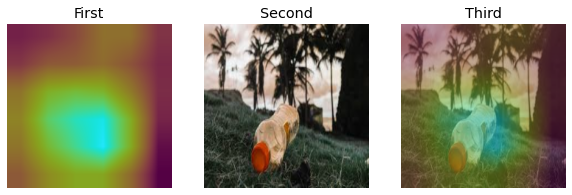

In [29]:

import cv2
from matplotlib import pyplot as plt


fig = plt.figure(figsize=(10, 7))


rows = 2
columns = 3

# reading images
Image1 = heatmap
Image2 = image
Image3 = output

fig.add_subplot(rows, columns, 1)
plt.imshow(Image1)
plt.axis('off')
plt.title("First")

fig.add_subplot(rows, columns, 2)


plt.imshow(Image2)
plt.axis('off')
plt.title("Second")


fig.add_subplot(rows, columns, 3)

plt.imshow(Image3)
plt.axis('off')
plt.title("Third")


